# Apply HUX Mapping Technique to in-situ spacecraft observations

In [1]:
import matplotlib.pyplot as plt
from scipy import stats
from scipy import interpolate
import numpy as np
import scipy
import copy
import pickle
import math
import os
import datetime as dt 
import xarray as xr

from heliopy.data import ulysses
from heliopy.data import omni
from heliopy.data import ace
from heliopy.data import wind

import heliopy.data.spice as spicedata
import heliopy.spice as spice
from astropy.coordinates import SkyCoord
import astropy.units as u

from tools.MASweb import get_mas_path
from psipy.model import MASOutput
from psipy.data import sample_data
from psipy.model.variable import Variable

from code.archimedes_sprial import cmap_spiral, compute_phi_shift_forward, ballistic_approximation_ulysses
from code.hux_propagation import *
from code.carrington_dates import * 
from code.numerical_methods import apply_numerical_method

# matplotlib fontsize
%matplotlib notebook
%matplotlib inline
fs1=12
size=2
plt.rcParams['savefig.facecolor'] = 'white'

# Time intervals to study Ulysses

#### CR1852, CR1853, CR1865, CR1915, CR1925, CR1930, CR1934, CR1946,  CR1976, CR2008, CR2016, CR2026, CR2039, CR2060.

Download MAS solutions from [Predictive Science Inc. website](http://www.predsci.com/data/runs).

For more information about reading MHD solutions see [PsiPy documentation website](https://psipy.readthedocs.io/en/stable/guide/getting_started.html#getting-data).

In [ ]:
case_study = "cr1976"
starttime, endtime, cr = get_time_interval(case_study)

In [3]:
print("start = ", starttime)
print("end = ", endtime)

start =  2003-09-26 00:00:00
end =  2003-10-23 00:00:00


In [4]:
# create directory to save figures
try:
    os.mkdir("figures/ulysses/" + case_study + "/")
except OSError as error:
    print(error)

[WinError 183] Cannot create a file when that file already exists: 'figures/ulysses/cr2008/'


In [5]:
# mas output - br, rho, vr
# 11852 kpo_mas_mas_std_0101

mas_path = get_mas_path(cr=cr, folder="kpo_mas_mas_std_0101/")

print(mas_path)
model = MASOutput(mas_path)

print(model.variables)

C:\Users\Opali\data\mas_helio\cr2008
['br', 'rho', 'vr']


In [6]:
# read in MHD velocity results. 
vr_model = model['vr']

In [7]:
# save MHD mesh coordinates Heliographic (rotating) Coordinate System (HG)
# phi - (0, 2pi)
p = vr_model.phi_coords
# sin(theta) - (-pi/2, pi/2)
t = vr_model.theta_coords
# 30 solar radii to approximately 1 AU
r = vr_model.r_coords
# velocity profile 
f = vr_model.data
# set omega rotation at the equator.
omega_rot=(2 * np.pi) / (25.38 * 86400)

In [8]:
print("Velocity matrix shape: ", np.shape(f))
print("Phi dim: ", np.shape(f)[0])
print("Theta dim: ", np.shape(f)[1])
print("Radial dim: ", np.shape(f)[2])
print("Velocity matrix dtype: ", f.dtype)


Velocity matrix shape:  (128, 111, 140)
Phi dim:  128
Theta dim:  111
Radial dim:  140
Velocity matrix dtype:  float32


In [9]:
# force periodicity on f
# since the last phi index is less than 2*pi, then we will append 2*pi to phi scale.
p_plot = np.append(p, 2*np.pi) 

# Phi: from radians to degrees. longitude.
p_plot = (180/np.pi)*p_plot

In [10]:
# append the first slice p=0 to velocity matrix. 
f_plot = np.append(f,[f[0,:, :]],axis=0)

In [11]:
# Radius: from solar radii to km. 
# 1 solar radii = 695,700 km
r_plot = (695700)*r

In [12]:
# convert to sin(Lat.) [-1, 1]
t_plot = np.sin(t)

In [13]:
# NOTE: pcolorfast and pcolormesh want the coords of pixel corners not centers --> build a "half mesh" for p & t.
# - This means making an array that is n+1 size and has the midpoint positions of the original.
# - Here we clip the endpoints of the half mesh to the original bounds, vs extrapolate.
# - see also https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolormesh.html.

cmap = 'gnuplot'

ph = np.concatenate([[p_plot[0]], 0.5 * (p_plot[1:] + p_plot[:-1]), [p_plot[-1]]])
th = np.concatenate([[t_plot[0]], 0.5 * (t_plot[1:] + t_plot[:-1]), [t_plot[-1]]])

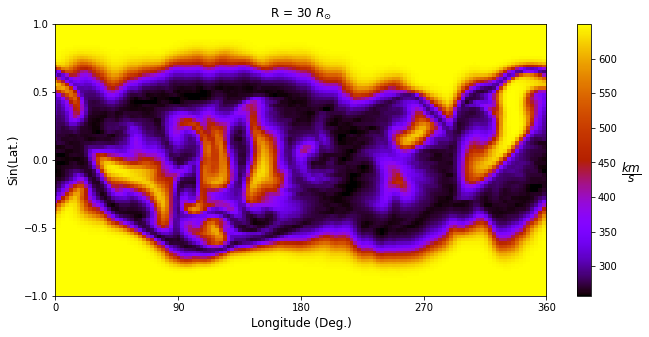

In [14]:
fig, ax = plt.subplots(figsize = (11,5))
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 30 $R_{\odot}$", fontsize=fs1)
ax.set_ylabel("Sin(Lat.)", fontsize=fs1)
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph, th, f_plot[:, :, 0].T, cmap=cmap)
cb = fig.colorbar(im, ax=ax)
cb.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)
#plt.savefig('figures/ulysses/' + case_study + '/vr_30rs_map.png')

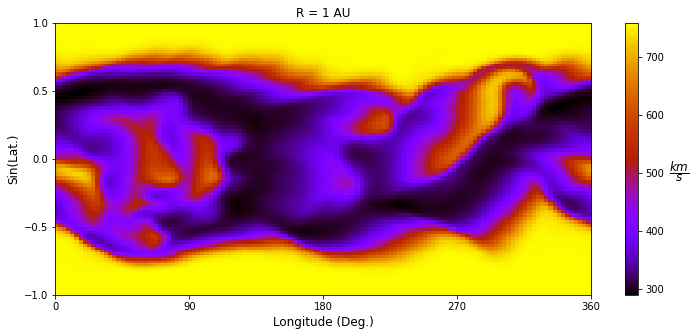

In [16]:
fig, ax = plt.subplots(figsize = (12,5))
ax.set_ylim(-1, 1)
ax.set_xlim(0, 360)
ax.set_title("R = 1 AU", fontsize=fs1)
ax.set_ylabel("Sin(Lat.)", fontsize=fs1)
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax.pcolorfast(ph, th, f_plot[:, :, -1].T, cmap=cmap)
cb = fig.colorbar(im, ax=ax)
cb.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)
#plt.savefig('figures/ulysses/' + case_study + '/vr_1au_map.png')

# Apply Heliospheric Upwind eXtrapolation method 

The HUX underlying PDE (Simplified fluid momentum equation in a corotating frame of reference):

$$
-\Omega_{rot}\frac{\partial v_{r}}{\partial \phi} + v_{r}\frac{ \partial v_{r}}{\partial r}=0
$$

With the initial condition 
$$
v_{r}(\phi, r_{0}) = v_{r0}(\phi)
$$

The HUX-f technique leverages the forward upwind difference method, such that
$$
-\Omega_{rot} \frac{v_{i, j+1} - v_{i, j}}{\Delta \phi} + 
v_{i, j}(\frac{v_{i+1, j} - v_{i, j}}{\Delta r}) = 0
$$


$$
v_{i+1, j}=  v_{i, j} + \frac{\Delta r\Omega_{rot}}{v_{i, j}}  (\frac{v_{i, j+1} - v_{i, j}}{\Delta \phi})
$$

Whereas HUX-b technique leverages the backwards finite difference approximation, such that 

$$
-\Omega_{rot} \frac{v_{i, j} - v_{i, j-1}}{\Delta \phi} + 
v_{i, j}(\frac{v_{i, j} - v_{i-1, j}}{\Delta r}) = 0
$$


$$
v_{i-1, j}=  v_{i, j} + \frac{\Delta r\Omega_{rot}}{v_{i, j}}  (\frac{v_{i, j}-v_{i, j-1}}{\Delta \phi})
$$

where for simplicity the $r$ subscipt on the radial velocity is omitted. The indicies $i$ and $j$ refer to $r$ and $\phi$ grids repectively in HG coordinates. 



# References

[1] Riley P and Lionello R (2011) "Mapping Solar Wind Streams from the Sun to 1 AU: A Comparison of Techniques". Solar Phys.270, 575–592. 

[2] Riley P and Issan O (2021) "Using a Heliospheric Upwinding eXtrapolation Technique to Magnetically Connect Different Regions of the Heliosphere". Front. Phys. 9:679497.

In [17]:
# get solar equator slices and save delta r and delta p arrays for hux propagation. 
solar_equator_r_30_radii = f[:, 55, 0]
solar_equator_r_1_au = f[:, 55, -1]
dr_vec = r_plot[1:] - r_plot[:-1]
dp_vec = p[1:] - p[:-1]

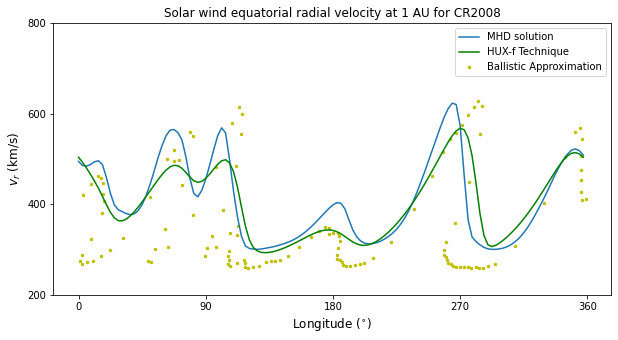

In [18]:
fig, ax = plt.subplots(figsize = (10,5))

_ = ax.plot(p*180/np.pi, solar_equator_r_1_au, label="MHD solution")
_ = ax.plot(p*180/np.pi, apply_forward_upwind_model(solar_equator_r_30_radii, dr_vec, dp_vec),
            'g',label="HUX-f Technique")

_ = ax.scatter(apply_ballistic_approximation(np.array(solar_equator_r_30_radii), 
                r_plot[-1] - r_plot[0], p)*180/np.pi, 
                solar_equator_r_30_radii, 
                color='y',s = 6, label="Ballistic Approximation")
            
_ = ax.set_title("Solar wind equatorial radial velocity at 1 AU for CR" + str(cr) ,fontsize=fs1)
_ = ax.set_xlabel("Longitude ($^{\circ}$)",fontsize=fs1)
_ = ax.set_yticks(ticks=[200, 400, 600, 800])

_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_ylabel('$v_{r}$ (km/s)',fontsize=fs1)
_ = plt.legend()
plt.savefig('figures/ulysses/' + case_study + '/vr_1AU_ts_comp_MHD_HUX-f.png')

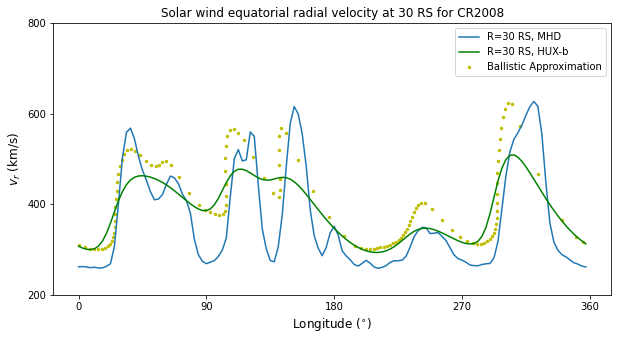

In [19]:
fig, ax = plt.subplots(figsize = (10,5))

_ = ax.plot(p*180/np.pi, solar_equator_r_30_radii , label="R=30 RS, MHD")
_ = ax.plot(p*180/np.pi, apply_backwards_upwind_model(solar_equator_r_1_au, dr_vec, dp_vec),
            'g',label="R=30 RS, HUX-b")


_ = ax.scatter(apply_ballistic_approximation(np.array(solar_equator_r_1_au), 
                r_plot[0]- r_plot[-1], p)*180/np.pi, 
                solar_equator_r_1_au, 
                color='y',s=6, label="Ballistic Approximation")

_ = ax.set_title("Solar wind equatorial radial velocity at 30 RS for CR" + str(cr),fontsize=fs1)
_ = ax.set_xlabel("Longitude ($^{\circ}$)",fontsize=fs1)
_ = ax.set_yticks(ticks=[200, 400, 600, 800])
_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_ylabel('$v_{r}$ (km/s)',fontsize=fs1)
_ = plt.legend()
#plt.savefig('figures/' + case_study + '/vr_30RS_ts_comp_MHD_HUX-b_cr' + str(cr) +'.png')

In [20]:
# apply the hux technique to all theta slices
hux_f_res, hux_b_res = np.ones((len(p), len(t), len(r))),  np.ones((len(p), len(t), len(r)))

for ii in range(len(t)):
    hux_f_res[:, ii, :] = apply_hux_f_model(f[:, ii, 0], dr_vec, dp_vec).T
    hux_b_res[:, ii, :] = apply_hux_b_model(f[:, ii, -1], dr_vec, dp_vec).T

In [21]:
# force periodicity when plotting
hux_f_res_plot = np.append(hux_f_res,[hux_f_res[0, :, :]], axis=0)
hux_b_res_plot = np.append(hux_b_res,[hux_b_res[0, :, :]], axis=0)

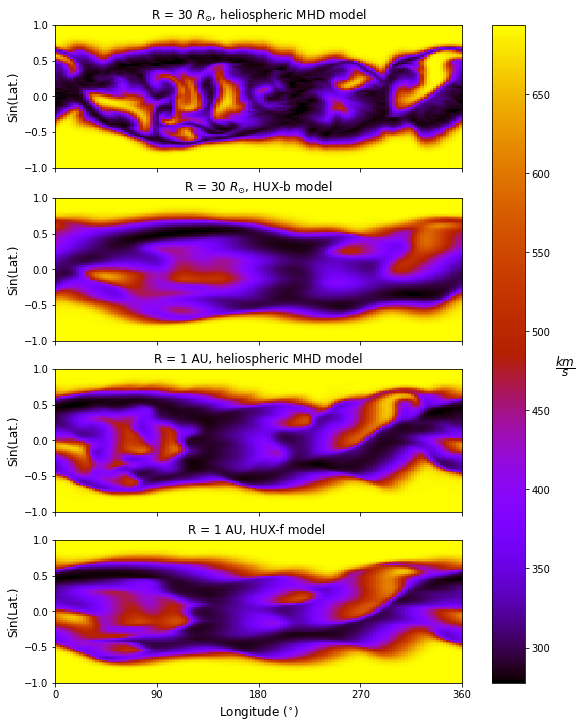

In [22]:
plt.rcParams['figure.figsize'] = [8, 10] # default fig size.

fig, ax = plt.subplots(nrows=4, ncols=1, constrained_layout=True, sharex=True)

ax[0].set_ylim(-1, 1)
ax[0].set_xlim(0, 360)
ax[0].set_title("R = 30 $R_{\odot}$, heliospheric MHD model", fontsize=fs1)
ax[0].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[0].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[0].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[0].pcolorfast(ph, th, f_plot[:, :, 0].T, cmap=cmap)

ax[1].set_ylim(-1, 1)
ax[1].set_xlim(0, 360)
ax[1].set_title("R = 30 $R_{\odot}$, HUX-b model", fontsize=fs1)
ax[1].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[1].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[1].pcolorfast(ph, th, hux_b_res_plot[:, :, 0].T, cmap=cmap)


ax[2].set_ylim(-1, 1)
ax[2].set_xlim(0, 360)
ax[2].set_title("R = 1 AU, heliospheric MHD model", fontsize=fs1)
ax[2].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[2].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[2].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[2].pcolorfast(ph, th, f_plot[:, :, -1].T, cmap=cmap)


ax[3].set_ylim(-1, 1)
ax[3].set_xlim(0, 360)
ax[3].set_title("R = 1 AU, HUX-f model ", fontsize=fs1)
ax[3].set_ylabel("Sin(Lat.)", fontsize=fs1)
ax[3].set_xlabel("Longitude ($^{\circ}$)", fontsize=fs1)
ax[3].set_yticks(ticks=[-1, -0.5, 0, 0.5, 1])
ax[3].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = im = ax[3].pcolorfast(ph, th, hux_f_res_plot[:, :, -1].T, cmap=cmap)
cbar = fig.colorbar(im, ax=ax.flat)
cbar.set_label('$\dfrac{km}{s}$', fontsize=fs1, rotation=360, labelpad=15)

plt.savefig('figures/ulysses/' + case_study + '/vr_lon_lat_maps_MHD_HUX.png')

# Read in Ulysses observations

In [23]:
ulysses_data = ulysses.swoops_ions(starttime, endtime)
print("Available data = ", ulysses_data.columns)

Available data =  ['r', 'hlat', 'hlon', 'n_p', 'n_a', 'T_p_large', 'T_p_small', 'v_r', 'v_t', 'v_n', 'iqual']


In [24]:
ulysses_data.data

,r,hlat,hlon,n_p,n_a,T_p_large,T_p_small,v_r,v_t,v_n,iqual
Time,,,,,,,,,,,
2003-09-26 00:03:19,5.1674,7.72,156.35,0.07140,0.00105,50061.0,18058.0,491.5,-8.0,-21.2,1
2003-09-26 00:11:21,5.1674,7.72,156.27,0.07292,0.00149,50425.0,18417.0,490.1,-9.0,-18.8,0
2003-09-26 00:19:23,5.1674,7.72,156.19,0.06613,0.00149,56345.0,20760.0,495.4,-13.0,-17.5,1
2003-09-26 00:26:59,5.1674,7.72,156.11,0.06883,0.00108,48937.0,17271.0,487.8,-7.5,-16.0,0
2003-09-26 00:35:01,5.1674,7.72,156.03,0.06927,0.00119,45682.0,16908.0,485.5,-5.7,-16.9,0
...,...,...,...,...,...,...,...,...,...,...,...
2003-10-22 23:24:04,5.2112,6.29,134.00,0.01842,0.00066,37375.0,6955.0,492.4,-13.8,-8.8,1
2003-10-22 23:32:06,5.2112,6.29,133.92,0.01674,0.00059,48651.0,9280.0,493.9,-11.8,-9.1,0
2003-10-22 23:40:06,5.2112,6.29,133.84,0.02027,0.00075,37384.0,8233.0,491.1,-14.7,-5.5,0


Generate the Ulysses trajectory in Heliographic (rotating) Coordinate System (HG).

We take the timestamps from the previously loaded data, and use `heliopy.spice`
to generate the trajectory at these times.

In [25]:
times = ulysses_data.index

spicedata.get_kernel('ulysses')
ulysses_traj = spice.Trajectory('Ulysses')
ulysses_traj.generate_positions(times=times, observing_body='Sun', frame='IAU_SUN')
ulysses_coords = ulysses_traj.coords

Generate the OMNI (Earth) trajectory in Heliographic (rotating) Coordinate System (HG).

We take the timestamps from the previously loaded data, and use `heliopy.spice`
to generate the trajectory at these times.

In [26]:
earth_traj = spice.Trajectory('Earth')
earth_traj.generate_positions(times=ulysses_data.index, observing_body='Sun', frame='IAU_SUN')
earth_coords = earth_traj.coords

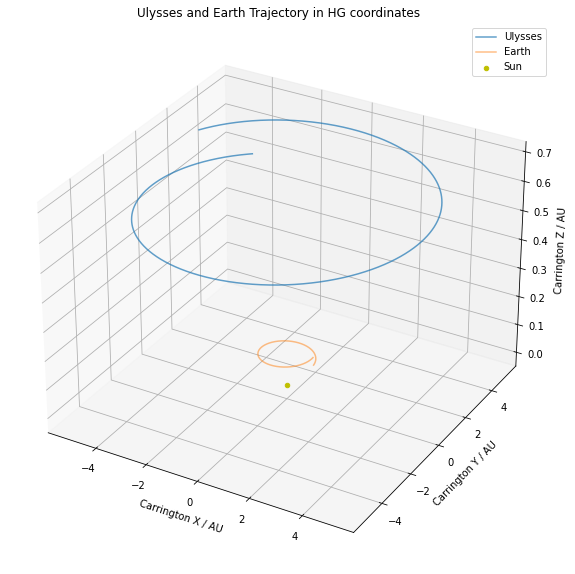

In [27]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')


_ = ax.plot3D(ulysses_traj.x.to(u.au), ulysses_traj.y.to(u.au), ulysses_traj.z.to(u.au), alpha=0.7, label="Ulysses")
_  = ax.plot3D(earth_traj.x.to(u.au), earth_traj.y.to(u.au), earth_traj.z.to(u.au), alpha=0.5, label="Earth")
_ = ax.scatter3D(0, 0, 0, color="y", label="Sun")

_ = ax.set_xlabel("Carrington X / AU")
_ = ax.set_ylabel("Carrington Y / AU")
_ = ax.set_zlabel("Carrington Z / AU")
_ = ax.legend()

_ = ax.set_title("Ulysses and Earth Trajectory in HG coordinates")
#plt.savefig('figures/ulysses/ulysses_trajectory_location.png')

In [28]:
print("Ulysses min lat = ", np.min(ulysses_coords.lat.to(u.rad)))
print("Ulysses max lat = ", np.max(ulysses_coords.lat.to(u.rad)))


Ulysses min lat =  0.107811rad
Ulysses max lat =  0.132769rad


In [29]:
print("Earth min lat = ", np.min(earth_coords.lat.to(u.rad)))
print("Earth max lat = ", np.max(earth_coords.lat.to(u.rad)))

Earth min lat =  0.0919092rad
Earth max lat =  0.121203rad


In [30]:
r_to_ulysses_hux_f_30rs = np.linspace(r_plot[0], np.max(ulysses_coords.radius.to(u.km).value), 300)
r_to_ulysses_hux_f_1au = np.linspace(r_plot[-1], np.max(ulysses_coords.radius.to(u.km).value), 200)

In [31]:
# apply the hux technique to all theta slices
hux_f_res, hux_b_res = np.ones((len(p), len(t), len(r_to_ulysses_hux_f_30rs))),  np.ones((len(p), len(t), len(r_to_ulysses_hux_f_1au)))

for ii in range(len(t)):
    hux_f_res[:, ii, :] = apply_hux_f_model(f[:, ii, 0], r_to_ulysses_hux_f_30rs[1:] - r_to_ulysses_hux_f_30rs[:-1], dp_vec).T
    hux_b_res[:, ii, :] = apply_hux_f_model(f[:, ii, -1], r_to_ulysses_hux_f_1au[1:] - r_to_ulysses_hux_f_1au[:-1], dp_vec).T

In [32]:
data_hux_f = xr.DataArray(hux_f_res, dims=['phi', 'theta', 'r'],
                            coords=[p* u.rad, t* u.rad, (r_to_ulysses_hux_f_30rs*(u.km)).to(u.solRad)])

hux_f_model = Variable(data=data_hux_f, name="vr", unit=vr_model._unit)

In [33]:
data_hux_b = xr.DataArray(hux_b_res, dims=['phi', 'theta', 'r'],
                            coords=[p* u.rad, t* u.rad, (r_to_ulysses_hux_f_1au*(u.km)).to(u.solRad)])

hux_b_model = Variable(data=data_hux_b, name="vr", unit=(u.km/u.second))

In [34]:
# interpolate where the spacecraft trajectory is - Ulysses
vr_sampled_hux_f = hux_f_model.sample_at_coords(lon=ulysses_coords.lon,
                                                lat=ulysses_coords.lat,
                                                r=ulysses_coords.radius)

vr_sampled_hux_b = hux_b_model.sample_at_coords(lon=ulysses_coords.lon,
                                                lat=ulysses_coords.lat,
                                                r=ulysses_coords.radius)

In [35]:
ballistic_ic_30rs = vr_model.sample_at_coords(lon=ulysses_coords.lon,
                                                lat=ulysses_coords.lat,
                                                r=np.ones(len(ulysses_coords.lon))*r[0]*u.solRad)

ballistic_ic_1au = vr_model.sample_at_coords(lon=ulysses_coords.lon,
                                                lat=ulysses_coords.lat,
                                                r=np.ones(len(ulysses_coords.lon))*r[-1]*u.solRad)

In [36]:
res_ballistic_f_30rs = ballistic_approximation_ulysses(r0_vec= np.ones(len(ulysses_coords.lon))*r[0]*u.solRad, 
                                                  rf_vec=ulysses_coords.radius, 
                                                  phi_vec=ulysses_coords.lon, 
                                                  vr_initial=ballistic_ic_30rs)

res_ballistic_f_1au = ballistic_approximation_ulysses(r0_vec= np.ones(len(ulysses_coords.lon))*r[-1]*u.solRad, 
                                                  rf_vec=ulysses_coords.radius, 
                                                  phi_vec=ulysses_coords.lon, 
                                                  vr_initial=ballistic_ic_1au)

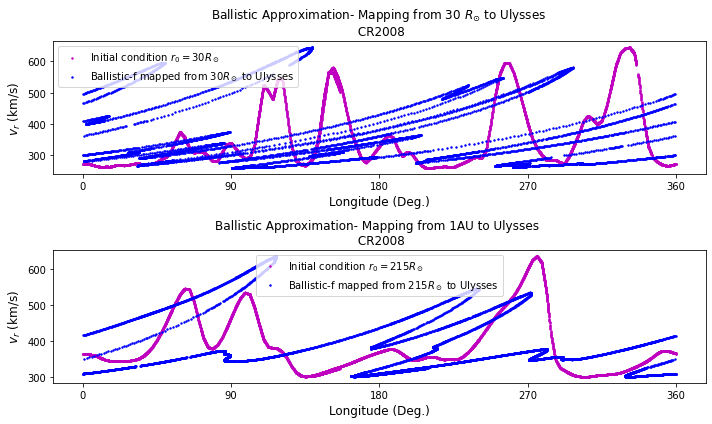

In [37]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 6))

_ = ax[0].scatter(ulysses_coords.lon, ballistic_ic_30rs, color="m", s=size, label="Initial condition $r_{0} = 30 R_\odot$")
_ = ax[0].scatter(res_ballistic_f_30rs*(180/np.pi), ballistic_ic_30rs, color="b", s=size, label="Ballistic-f mapped from $30 R_\odot$ to Ulysses")

_ = ax[0].set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax[0].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax[0].set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax[0].set_title("Ballistic Approximation- Mapping from 30 $R_{\odot}$ to Ulysses \n CR" + str(cr))
_ = ax[0].legend()

_ = ax[1].scatter(ulysses_coords.lon, ballistic_ic_1au, color="m", s=size, label="Initial condition $r_{0} = 215 R_\odot$")
_ = ax[1].scatter(res_ballistic_f_1au*(180/np.pi), ballistic_ic_1au, color="b", s=size, label="Ballistic-f mapped from $215 R_\odot$ to Ulysses")

_ = ax[1].set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax[1].set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax[1].set_title("Ballistic Approximation- Mapping from 1AU to Ulysses \n CR" + str(cr))
_ = ax[1].legend()
_ = plt.tight_layout()

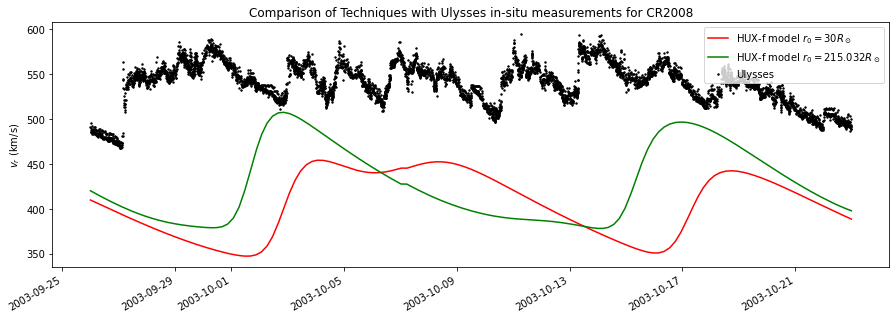

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(times, ulysses_data.quantity('v_r'), color="k",s=2,  label='Ulysses')
ax.plot(times, vr_sampled_hux_f, color="r", label='HUX-f model $r_{0} = 30 R_\odot$')
ax.plot(times, vr_sampled_hux_b, color="g", label='HUX-f model $r_{0} = 215.032 R_\odot$')

ax.set_ylabel(r'$v_{r}$ (km/s)')
ax.legend()
ax.set_title("Comparison of Techniques with Ulysses in-situ measurements for CR" + str(cr))
fig.autofmt_xdate()

plt.savefig('figures/ulysses/'+ case_study + '/ulysses_comparison_cr'+ str(cr)+ '_time.png')

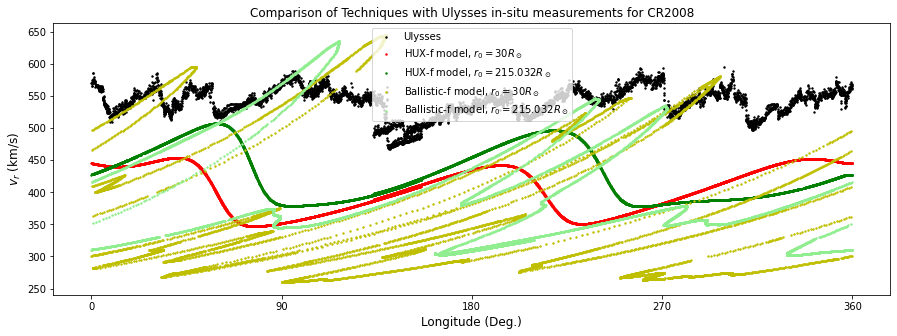

In [39]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.scatter(ulysses_coords.lon, ulysses_data.quantity('v_r'), color="k", s=size,  label="Ulysses")
ax.scatter(ulysses_coords.lon, vr_sampled_hux_f, color="r", s=size, label='HUX-f model, $r_{0} = 30 R_\odot$')
ax.scatter(ulysses_coords.lon, vr_sampled_hux_b, color="g", s=size, label='HUX-f model, $r_{0} = 215.032 R_\odot$')
ax.scatter(res_ballistic_f_30rs*(180/np.pi),  ballistic_ic_30rs, color="y", s=size, label="Ballistic-f model, $r_{0} = 30 R_\odot$")
ax.scatter(res_ballistic_f_1au*(180/np.pi),  ballistic_ic_1au, color="lightgreen", s=size, label="Ballistic-f model, $r_{0} = 215.032 R_\odot$")


ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
ax.set_xticks(ticks=[0, 90, 180, 270, 360])
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.set_title("Comparison of Techniques with Ulysses in-situ measurements for CR" + str(cr))
ax.legend()
plt.savefig('figures/ulysses/'+ case_study + '/ulysses_comparison_cr' + str(cr) + '_carrington_longitude.png')

# Read in OMNI (Earth) Observations

• OMNI data set for solar wind speed observations can be found https://spdf.gsfc.nasa.gov/pub/data/omni/low_res_omni/

The WIND spacecraft was launched on November 1, 1994 and ACE was launched in August 25, 1997. 

In [40]:
omni_data = omni.h0_mrg1hr(starttime, endtime)

In [41]:
omni_data.data

,Epoch_1800,Rot1800,IMF1800,PLS1800,IMF_PTS1800,PLS_PTS1800,ABS_B1800,F1800,THETA_AV1800,PHI_AV1800,...,F10_INDEX,KP,DST,AE,AP_INDEX,AL_INDEX,AU_INDEX,PC_N_INDEX,Solar_Lyman_alpha,Proton_QI
Time,,,,,,,,,,,,,,,,,,,,,
2003-09-26 01:00:00,6.323176e+13,2322,71,71,15,15,4.5,3.8,41.799999,162.300003,...,131.800003,30,-25,373,15,-256,117,1.4,0.008285,0.0080
2003-09-26 02:00:00,6.323176e+13,2322,71,71,15,15,5.1,4.3,42.700001,219.600006,...,131.800003,30,-22,241,15,-153,88,0.9,0.008285,0.0106
2003-09-26 03:00:00,6.323177e+13,2322,71,71,15,15,4.7,4.3,24.600000,149.600006,...,131.800003,27,-19,71,12,-8,63,0.5,0.008285,0.0089
2003-09-26 04:00:00,6.323177e+13,2322,71,71,15,15,4.4,4.1,-4.700000,151.500000,...,131.800003,27,-18,75,12,-19,56,0.9,0.008285,0.0079
2003-09-26 05:00:00,6.323177e+13,2322,71,71,15,15,4.5,3.0,18.299999,177.100006,...,131.800003,27,-24,319,12,-199,120,1.5,0.008285,0.0092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2003-10-22 19:00:00,6.323407e+13,2323,71,71,15,15,11.6,11.5,78.300003,34.599998,...,152.000000,37,-32,65,22,-41,25,-1.1,0.007958,0.0392
2003-10-22 20:00:00,6.323407e+13,2323,71,71,15,15,11.8,11.8,84.699997,349.600006,...,152.000000,37,-30,40,22,-25,15,-1.2,0.007958,0.0587
2003-10-22 21:00:00,6.323408e+13,2323,71,71,15,15,11.7,11.7,82.000000,282.600006,...,152.000000,17,-28,49,6,-24,25,-0.5,0.007958,0.0539


Generate the OMNI (Earth) trajectory in Heliographic (rotating) Coordinate System (HG).

We take the timestamps from the previously loaded data, and use `heliopy.spice`
to generate the trajectory at these times.

In [42]:
earth_traj = spice.Trajectory('Earth')
earth_traj.generate_positions(times=omni_data.index, observing_body='Sun', frame='IAU_SUN')
earth_coords = earth_traj.coords

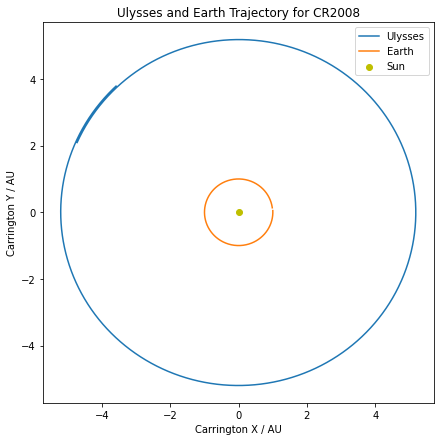

In [43]:
fig, ax = plt.subplots(figsize=(7, 7))
_ = ax.plot(ulysses_coords.radius.to("AU")* np.cos(ulysses_coords.lon.value*np.pi/180), ulysses_coords.radius.to("AU")* np.sin(ulysses_coords.lon.value*np.pi/180), label="Ulysses")
_ = ax.plot(earth_coords.radius.to("AU")* np.cos(earth_coords.lon.value*np.pi/180), earth_coords.radius.to("AU")* np.sin(earth_coords.lon.value*np.pi/180), label="Earth")
_ = ax.scatter(0, 0, color="y", label="Sun")

_ = ax.set_xlabel("Carrington X / AU")
_ = ax.set_ylabel("Carrington Y / AU")
_ = ax.legend()
_ = ax.set_title("Ulysses and Earth Trajectory for CR" + str(case_study[2:]))
plt.savefig('figures/ulysses/'+ case_study + '/ulysses__earth_location.png')

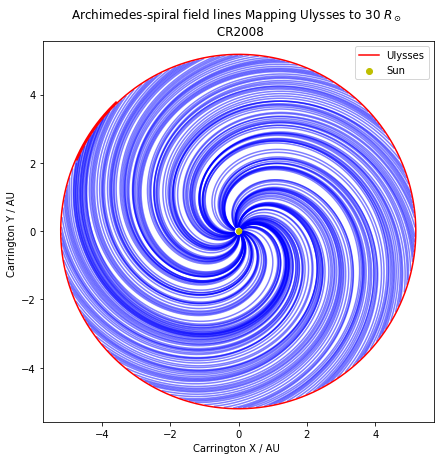

In [44]:
nphi = len(ulysses_coords.lon.value)
nrout = 201

fig, ax = plt.subplots(figsize=(7, 7))


for ii in np.arange(0, nphi, 40):
    # phi location ulysses. 
    phi_location = (ulysses_coords.lon[ii].to(u.rad)).value
    # radial location ulysses. 
    radial_location = np.linspace(ulysses_coords.radius.to(u.km)[ii], ((r[0]*u.solRad).to(u.km)), nrout) 
    # vr at the certain point (p, r)
    curr_velocity = ulysses_data.quantity('v_r').value[ii]

    if not np.isnan(curr_velocity):
        phi_shift_vec = compute_phi_shift_forward(p=phi_location, 
                                                     r=radial_location.value,
                                                     v=curr_velocity) 

        x = np.cos(phi_shift_vec)*radial_location.to(u.AU)
        y = np.sin(phi_shift_vec)*radial_location.to(u.AU)

        _ = ax.plot(x[1:], y[1:], c="b", alpha=0.5)

ax.plot(ulysses_coords.radius.to("AU")* np.cos(ulysses_coords.lon.value*np.pi/180), ulysses_coords.radius.to("AU")* np.sin(ulysses_coords.lon.value*np.pi/180), c="r", label="Ulysses")
#ax.plot(earth_coords.radius.to("AU")* np.cos(earth_coords.lon.value*np.pi/180), earth_coords.radius.to("AU")* np.sin(earth_coords.lon.value*np.pi/180), c="g", label="Earth")
ax.scatter(0, 0, color="y", label="Sun")
ax.set_title("Archimedes-spiral field lines Mapping Ulysses to 30 $R_\odot$ \n CR" + str(case_study[2:]))
ax.set_xlabel("Carrington X / AU ")
ax.set_ylabel("Carrington Y / AU ")
plt.axis("equal")
plt.legend()

plt.savefig('figures/ulysses/'+ case_study + '/Archimedes_spiral_ulysses_to30rs.png')

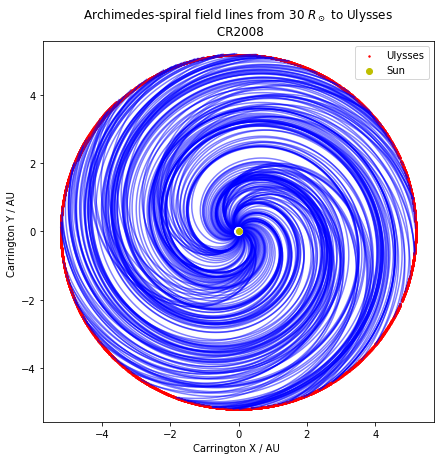

In [45]:
fig, ax = plt.subplots(figsize=(7, 7))


for ii in np.arange(0, nphi, 40):
    # phi location mhd results. 
    phi_location = (ulysses_coords.lon[ii].to(u.rad)).value
    # radial location ulysses. 
    radial_location = np.linspace(((r[0]*u.solRad).to(u.km)), ulysses_coords.radius.to(u.km)[ii], nrout) 
    # vr at the certain point (p, r)
    curr_velocity = ballistic_ic_30rs.value[ii]

    if not np.isnan(curr_velocity):
        phi_shift_vec = compute_phi_shift_forward(p=phi_location, 
                                                     r=radial_location.value,
                                                     v=curr_velocity) 

        x = np.cos(phi_shift_vec)*radial_location.to(u.AU)
        y = np.sin(phi_shift_vec)*radial_location.to(u.AU)

        _ = ax.plot(x[1:], y[1:], c="b", alpha=0.5)

ax.scatter(ulysses_coords.radius.to("AU")* np.cos(ulysses_coords.lon.value*np.pi/180), ulysses_coords.radius.to("AU")* np.sin(ulysses_coords.lon.value*np.pi/180), s=size, c="r", label="Ulysses")
#ax.plot(earth_coords.radius.to("AU")* np.cos(earth_coords.lon.value*np.pi/180), earth_coords.radius.to("AU")* np.sin(earth_coords.lon.value*np.pi/180), c="g", label="Earth")
ax.scatter(0, 0, color="y", label="Sun")
ax.set_title("Archimedes-spiral field lines from 30 $R_\odot$ to Ulysses \n CR" + str(case_study[2:]))
ax.set_xlabel("Carrington X / AU ")
ax.set_ylabel("Carrington Y / AU ")
plt.axis("equal")
plt.legend()

plt.savefig('figures/ulysses/'+ case_study + '/Archimedes_spiral_ulysses_from30rs.png')

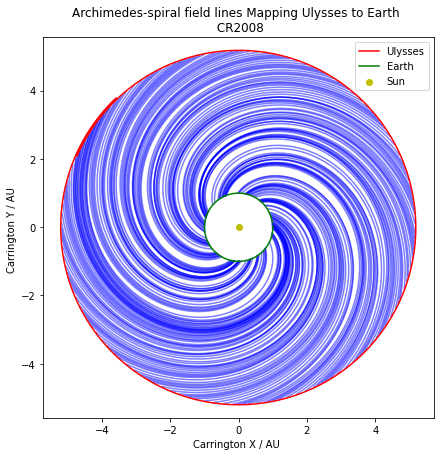

In [46]:
nphi = len(ulysses_coords.lon.value)
nrout = 201
earth_mean_r = np.mean(earth_coords.radius.to("AU").value)

fig, ax = plt.subplots(figsize=(7, 7))


for ii in np.arange(0, nphi, 40):
    # phi location ulysses. 
    phi_location = (ulysses_coords.lon.value[ii])*(np.pi/180)
    # radial location ulysses. 
    radial_location = np.linspace(ulysses_coords.radius.to("AU").value[ii], earth_mean_r, nrout)
    # change units to km.
    radial_location = radial_location * (u.AU)
    radial_location = radial_location.to(u.km)
    
    # vr at the certain point (p, r)
    curr_velocity = ulysses_data.quantity('v_r').value[ii]

    if not np.isnan(curr_velocity):
        phi_shift_vec = compute_phi_shift_forward(p=phi_location, 
                                                     r=radial_location.value,
                                                     v=curr_velocity) 

        x = np.cos(phi_shift_vec)*radial_location.to(u.AU)
        y = np.sin(phi_shift_vec)*radial_location.to(u.AU)

        _ = ax.plot(x[1:], y[1:], c="b", alpha=0.5)

ax.plot(ulysses_coords.radius.to("AU")* np.cos(ulysses_coords.lon.value*np.pi/180), ulysses_coords.radius.to("AU")* np.sin(ulysses_coords.lon.value*np.pi/180), c="r", label="Ulysses")
ax.plot(earth_coords.radius.to("AU")* np.cos(earth_coords.lon.value*np.pi/180), earth_coords.radius.to("AU")* np.sin(earth_coords.lon.value*np.pi/180), c="g", label="Earth")
ax.scatter(0, 0, color="y", label="Sun")
ax.set_title("Archimedes-spiral field lines Mapping Ulysses to Earth \n CR" + str(case_study[2:]))
ax.set_xlabel("Carrington X / AU ")
ax.set_ylabel("Carrington Y / AU ")
plt.axis("equal")
plt.legend()

plt.savefig('figures/ulysses/'+ case_study + '/Archimedes_spiral_ulysses.png')

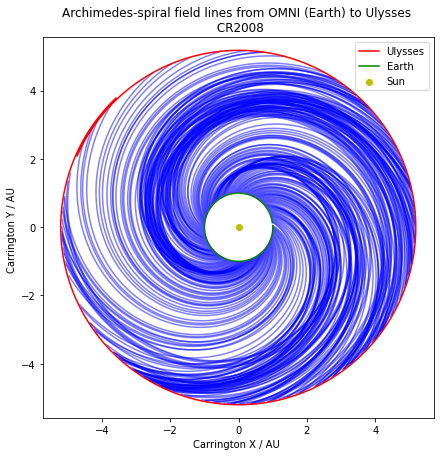

In [47]:
fig, ax = plt.subplots(figsize=(7, 7))

for ii in np.arange(0, len(earth_coords.lon), 3):
    # earth phi location. 
    phi_location = (earth_coords.lon.value[ii])*(np.pi/180)
    # earth radial location
    radial_location = np.linspace(earth_coords.radius.to("AU").value[ii], ulysses_coords.radius.to("AU").value[ii], nrout)
    # radial location in km units. 
    radial_location = radial_location * (u.AU)
    radial_location = radial_location.to(u.km)
    # v_r at earth. 
    curr_velocity = omni_data.quantity('V').value[ii]
        
    if not np.isnan(curr_velocity):
        phi_shift_vec = compute_phi_shift_forward(p=phi_location, 
                                                     r=radial_location.value,
                                                     v=curr_velocity) 

        x = np.cos(phi_shift_vec)*radial_location.to(u.AU)
        y = np.sin(phi_shift_vec)*radial_location.to(u.AU)

        _ = ax.plot(x[1:], y[1:], c="b", alpha=0.5)

ax.plot(ulysses_coords.radius.to("AU")* np.cos(ulysses_coords.lon.value*np.pi/180), ulysses_coords.radius.to("AU")* np.sin(ulysses_coords.lon.value*np.pi/180), c="r",  label="Ulysses")
ax.plot(earth_coords.radius.to("AU")* np.cos(earth_coords.lon.value*np.pi/180), earth_coords.radius.to("AU")* np.sin(earth_coords.lon.value*np.pi/180), c="g", label="Earth")
ax.scatter(0, 0, color="y", label="Sun")
ax.set_title("Archimedes-spiral field lines from OMNI (Earth) to Ulysses \n CR" + str(case_study[2:]))
ax.set_xlabel("Carrington X / AU ")
ax.set_ylabel("Carrington Y / AU ")
plt.axis("equal")
plt.legend()

plt.savefig('figures/ulysses/'+ case_study + '/Archimedes_spiral_omni.png')

In [48]:
vr_sampled_hux_f_omni = hux_f_model.sample_at_coords(earth_coords.lon,
                                                     earth_coords.lat,
                                                     earth_coords.radius)


vr_sampled_mhd_omni = vr_model.sample_at_coords(earth_coords.lon,
                                                earth_coords.lat,
                                                earth_coords.radius)

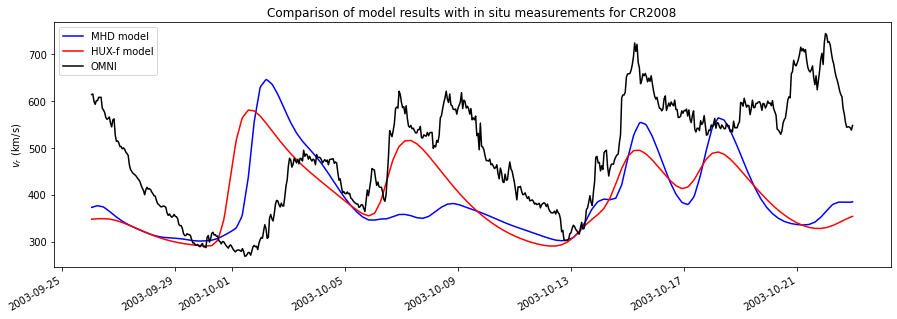

In [49]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(omni_data.index, vr_sampled_mhd_omni, color="b", label='MHD model')
ax.plot(omni_data.index, vr_sampled_hux_f_omni, color="r", label='HUX-f model')
ax.plot(omni_data.index, omni_data.quantity('V'),color="k", label='OMNI')

ax.set_ylabel(r'$v_{r}$ (km/s)')
ax.legend()
ax.set_title("Comparison of model results with in situ measurements for CR" + str(case_study[2:]))
fig.autofmt_xdate()

plt.savefig('figures/ulysses/'+ case_study + '/omni_comparison_cr' + str(cr) + '_time.png')

In [50]:
min_index = np.argmin(earth_coords.lon)

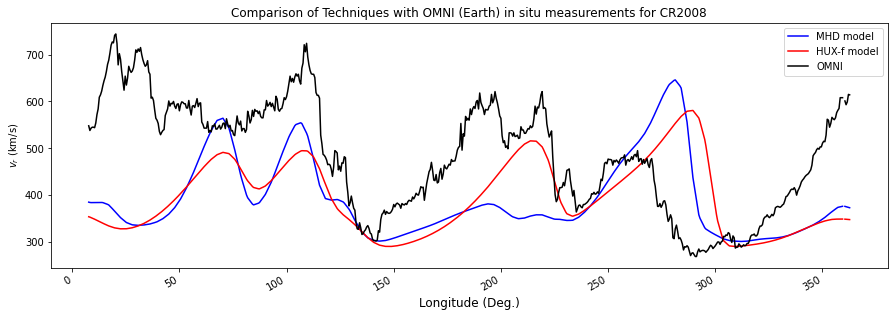

In [51]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(np.array(earth_coords.lon[:min_index])+360, vr_sampled_mhd_omni[:min_index], color="b", label="MHD model")
ax.plot(np.array(earth_coords.lon[:min_index])+360, vr_sampled_hux_f_omni[:min_index], color="r", label="HUX-f model")
ax.plot(np.array(earth_coords.lon[:min_index])+360, omni_data.quantity('V')[:min_index], color="k", label="OMNI")

ax.plot(earth_coords.lon[min_index+1:], vr_sampled_mhd_omni[min_index+1:], color="b")
ax.plot(earth_coords.lon[min_index+1:], vr_sampled_hux_f_omni[min_index+1:], color="r")
ax.plot(earth_coords.lon[min_index+1:], omni_data.quantity('V')[min_index+1:], color="k")

ax.set_ylabel(r'$v_{r}$ (km/s)')
ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax.legend()
ax.set_title("Comparison of Techniques with OMNI (Earth) in situ measurements for CR" + str(cr))
fig.autofmt_xdate()


plt.savefig('figures/ulysses/'+ case_study + '/omni_comparison_cr' + str(cr) + '_lon.png')

# Mapping Ulysses to OMNI (Earth) using the HUX-f and Ballistic Technique

# Assumptions: 
#### 1.  Latitude is constant in Ulysses trajectory coordinates 
* Note that HUX is dependent on $\phi$ and $r$ only. 

#### 2.  Ulysses and Earth are aligned in latitude. 

#### 3.  $\phi$ is monotonically increasing.


#### 4. Periodic Boundary Conditions

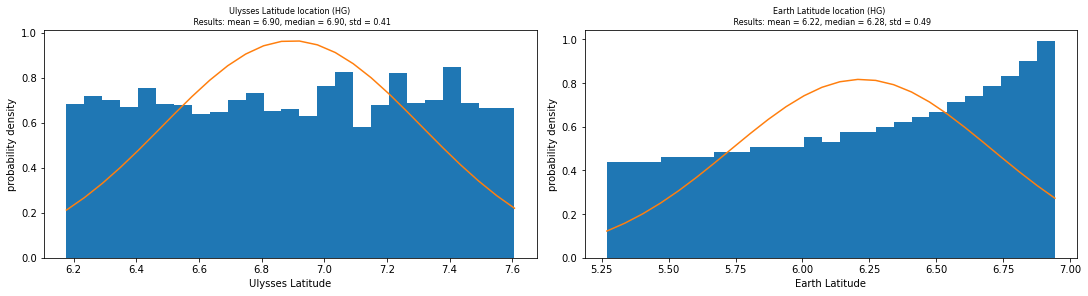

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 4))


## psp latitude trajectory 
mu, sigma = scipy.stats.norm.fit(ulysses_traj.coords.lat.value)

n , bins, _ = ax[0].hist(ulysses_traj.coords.lat.value, 25, density=1)
_ = ax[0].set_title("Ulysses Latitude location (HG) \n Results: mean = %.2f, median = %.2f, std = %.2f" % \
                       (mu, np.median(ulysses_traj.coords.lat.value), sigma), fontsize=8)
_ = ax[0].set_xlabel("Ulysses Latitude")
_ = ax[0].set_ylabel("probability density") 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax[0].plot(bins, best_fit_line)


## earth latitude trajectory 
mu, sigma = scipy.stats.norm.fit(earth_traj.coords.lat.value)

n , bins, _ = ax[1].hist(earth_traj.coords.lat.value, 25, density=1)
_ = ax[1].set_title("Earth Latitude location (HG) \n Results: mean = %.2f, median = %.2f, std = %.2f" % \
                       (mu, np.median(earth_traj.coords.lat.value), sigma), fontsize=8)
_ = ax[1].set_xlabel("Earth Latitude")
_ = ax[1].set_ylabel("probability density") 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax[1].plot(bins, best_fit_line)

plt.savefig('figures/ulysses/'+ case_study + '/ulysses_earth_lat_traj' + str(cr) + '_lon.png')

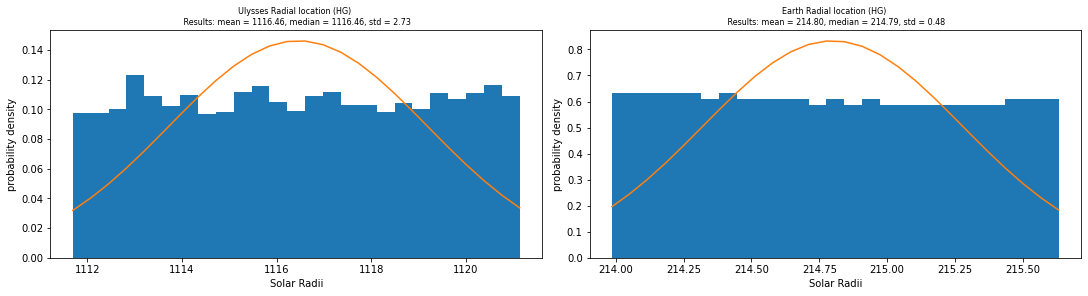

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 4))


## ulysses radial trajectory 
mu, sigma = scipy.stats.norm.fit(ulysses_traj.coords.radius.to(u.solRad).value)

n , bins, _ = ax[0].hist(ulysses_traj.coords.radius.to(u.solRad).value, 25, density=1)
_ = ax[0].set_title("Ulysses Radial location (HG) \n Results: mean = %.2f, median = %.2f, std = %.2f" % \
                       (mu, np.median(ulysses_traj.coords.radius.to(u.solRad).value), sigma), fontsize=8)
_ = ax[0].set_xlabel("Solar Radii")
_ = ax[0].set_ylabel("probability density") 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax[0].plot(bins, best_fit_line)


## earth radial trajectory 
mu, sigma = scipy.stats.norm.fit(earth_traj.coords.radius.to(u.solRad).value)

n , bins, _ = ax[1].hist(earth_traj.coords.radius.to(u.solRad).value, 25, density=1)
_ = ax[1].set_title("Earth Radial location (HG) \n Results: mean = %.2f, median = %.2f, std = %.2f" % \
                       (mu, np.median(earth_traj.coords.radius.to(u.solRad).value), sigma), fontsize=8)
_ = ax[1].set_xlabel("Solar Radii")
_ = ax[1].set_ylabel("probability density") 

best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
_ = ax[1].plot(bins, best_fit_line)

plt.savefig('figures/ulysses/'+ case_study + '/ulysses_earth_rad_traj' + str(cr) + '_lon.png')

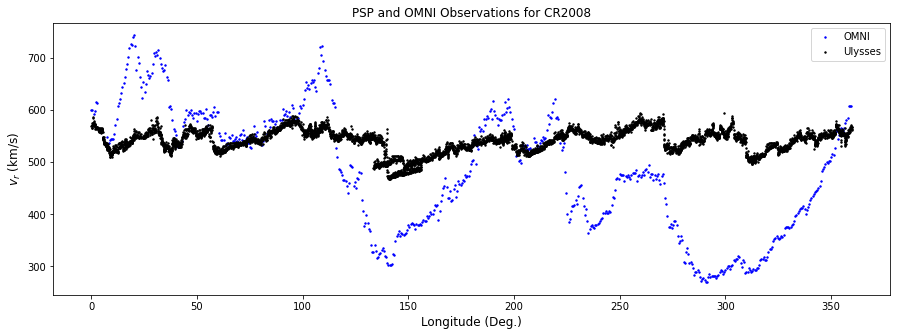

In [56]:
fig, ax = plt.subplots(figsize=(15, 5))

_ = ax.scatter(earth_coords.lon, omni_data.quantity('V'), color="b", s=size, label="OMNI")

_ = ax.scatter(ulysses_coords.lon, ulysses_data.quantity('v_r'), color="k", s=size, label="Ulysses")

_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()
_ = ax.set_title("PSP and OMNI Observations for CR" + str(cr))
plt.savefig('figures/ulysses/'+ case_study + '/omni_and_ulysses_vr_vs_carringtonlon' + str(cr) +'.png')

# Ballistic Mapping
 * Evaluate the characteristic lines - do they intersect? This happens when the PSP velocity function is decreasing. Otherwise, when the PSP velocity function is increasing it results in rarefaction wave. 
 

In [41]:
r_mean = np.linspace(np.mean(psp_coords.radius), np.mean(earth_coords.radius), 100)
r_min = np.linspace(np.min(psp_coords.radius), np.mean(earth_coords.radius), 100)
r_max = np.linspace(np.max(psp_coords.radius), np.mean(earth_coords.radius), 100)

In [42]:
omega_rot = (2 * np.pi) / (25.38 * 86400)

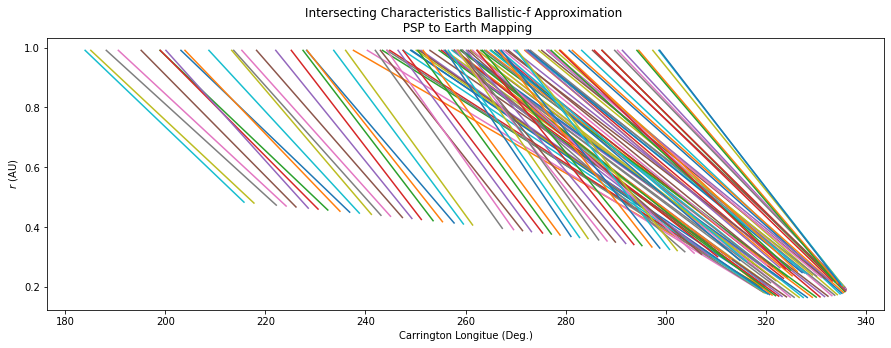

In [43]:
fig, ax = plt.subplots(figsize = (15,5))


for ii in np.arange(0, nphi, 100):
    phi_location = (lon_psp[ii])*(np.pi/180)
    radial_location = np.linspace(psp_coords.radius.to("AU").value[ii], earth_mean_r, nrout)
    radial_location = radial_location * (u.AU)
    radial_location = radial_location.to(u.km)
    curr_velocity = psp_data.quantity('VR').value[ii]

    if not np.isnan(curr_velocity):
        phi_shift_vec = compute_phi_shift_forward(p=phi_location, 
                                                     r=radial_location.value,
                                                     v=curr_velocity) 
        _ = ax.plot(phi_shift_vec*(180/np.pi), radial_location.to(u.AU))

_ = ax.set_xlabel("Carrington Longitue (Deg.)")
_ = ax.set_ylabel("$r$ (AU)")
_ = ax.set_title("Intersecting Characteristics Ballistic-f Approximation \n PSP to Earth Mapping")
plt.savefig('figures/psp/'+ case_study + '/intersecting_characteristics_ballistic_f' + str(cr) +'.png')

In [44]:
res_ballistic_f = np.zeros(nphi)
omega_rot=(2 * np.pi) / (25.38 * 86400)

for ii in range(nphi):
    phi_location = (lon_psp[ii])*(np.pi/180)
    r0 = psp_coords.radius.value[ii]
    rf = earth_mean_r *(u.AU)
    rf = rf.to(u.km).value
    curr_velocity = psp_data.quantity('VR').value[ii]
    dr = rf - r0
    delta_phi = (omega_rot * dr) / curr_velocity
    phi_shifted = phi_location - delta_phi
    # force periodicity
    res_ballistic_f[ii] = phi_shifted % (2 * np.pi)

<ipython-input-44-e03de64365f2>:14: RuntimeWarning: invalid value encountered in double_scalars
  res_ballistic_f[ii] = phi_shifted % (2 * np.pi)


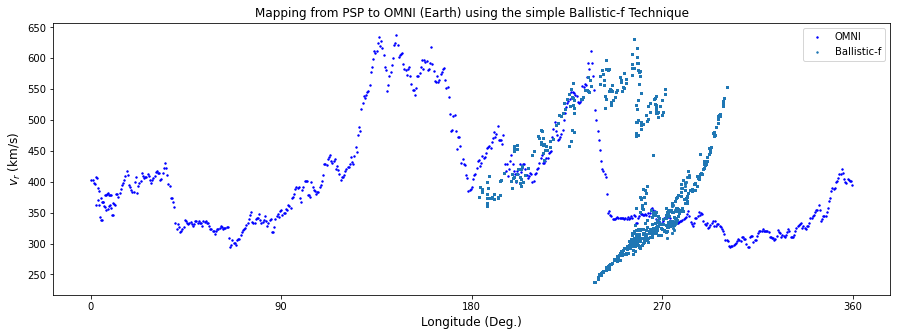

In [45]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.scatter(np.array(earth_coords.lon), omni_data.quantity('V'), color="b", s=size, label="OMNI")

_ = ax.scatter(res_ballistic_f*(180/np.pi), psp_data.quantity('VR'),s=2, label="Ballistic-f")

_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_title("Mapping from PSP to OMNI (Earth) using the simple Ballistic-f Technique")
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()


# HUX-f Technique
# 1D interpolation - input $\phi$ ranges from [0, 2$\pi$]

In [46]:
# get longitude limits
min_lon = np.inf
max_lon = -np.inf

for ii in range(len(psp_coords.lon.value)):
    if psp_coords.lon.value[ii] < min_lon and not math.isnan(psp_data.quantity('VR').value[ii]):
        min_lon = psp_coords.lon.value[ii]
    if psp_coords.lon.value[ii] > max_lon and not math.isnan(psp_data.quantity('VR').value[ii]):
        max_lon = psp_coords.lon.value[ii]

In [47]:
# create uniform phi 1d mesh grid. 

phi_array = np.linspace(0, 360, 361)

In [48]:
# drop NaNs
nan_idx = np.isfinite(psp_data.quantity('VR').value)
v_vec = psp_data.quantity('VR').value[nan_idx]
interp = interpolate.interp1d(psp_coords.lon.value[nan_idx], \
                              v_vec, fill_value=(400, 400),  bounds_error=False)
psp_interp = interp(phi_array)

C:\Users\Opali\AppData\Local\Continuum\anaconda3\envs\huxv1\lib\site-packages\scipy\interpolate\interpolate.py:623: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [49]:
# convert to radians
p_hux = phi_array * np.pi/180
# delta phi 
dp_vec_hux = p_hux[1:] - p_hux[:-1]

(215.70859456700973, 336.0822784520752)

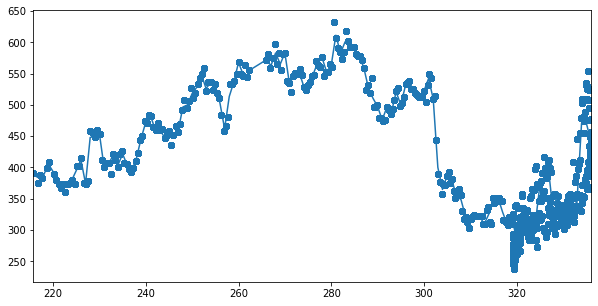

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(phi_array, psp_interp)
ax.scatter(psp_coords.lon.value, psp_data.quantity('VR').value)
ax.set_xlim(min_lon, max_lon)


In [51]:
res_hux_f_min = apply_forward_upwind_model(r_initial=psp_interp,
                                        dr_vec=r_min.value[1:] - r_min.value[:-1],
                                        dp_vec=dp_vec_hux, 
                                        add_v_acc=False, 
                                        r0=r_min[0].value)


res_hux_f_max = apply_forward_upwind_model(r_initial=psp_interp,
                                        dr_vec=r_max.value[1:] - r_max.value[:-1],
                                        dp_vec=dp_vec_hux, 
                                        add_v_acc=False, 
                                        r0=r_max[0].value)


res_hux_f_mean = apply_forward_upwind_model(r_initial=psp_interp,
                                        dr_vec=r_mean.value[1:] - r_mean.value[:-1],
                                        dp_vec=dp_vec_hux, 
                                        add_v_acc=False, 
                                        r0=r_mean[0].value)

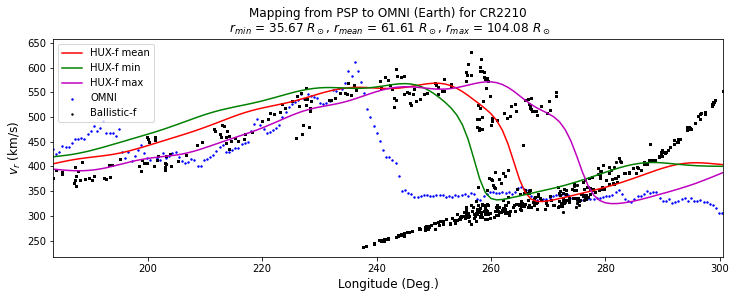

In [52]:
fig, ax = plt.subplots(figsize=(12,4))
_ = ax.scatter(np.array(earth_coords.lon), omni_data.quantity('V'), color="b", s=size, label="OMNI")

_ = ax.plot(phi_array, res_hux_f_mean, color="r", label="HUX-f mean")
_ = ax.plot(phi_array, res_hux_f_min, color="g", label="HUX-f min")
_ = ax.plot(phi_array, res_hux_f_max, color="m", label="HUX-f max")

_ = ax.scatter(res_ballistic_f*(180/np.pi), psp_data.quantity('VR').value, s=2, c="k", label="Ballistic-f")

_ = ax.set_xlim(np.nanmin(res_ballistic_f*(180/np.pi)), np.nanmax(res_ballistic_f*(180/np.pi)))

_ = ax.set_title("Mapping from PSP to OMNI (Earth) for CR" + str(cr)+ "\n $r_{min}$ = %.2f $R_\odot$, $r_{mean}$ = %.2f $R_\odot$, $r_{max}$ = %.2f $R_\odot$" % \
                       (np.min(psp_coords.radius).to(u.solRad).value,
                        np.mean(psp_coords.radius).to(u.solRad).value,
                        np.max(psp_coords.radius).to(u.solRad).value))
                 
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()

plt.savefig('figures/psp/'+ case_study + '/psp_to_omni_mapping' + str(cr) + '_lon.png')

# Map OMNI to PSP using the HUX-b and Ballistic Techniques

# Ballistic Mapping
 * evaluate the characteristic lines - do they intersect? This happens when the OMNI velocity function is increasing. Otherwise, when the OMNI velocity function is decreasing it results in rarefaction wave. 
 

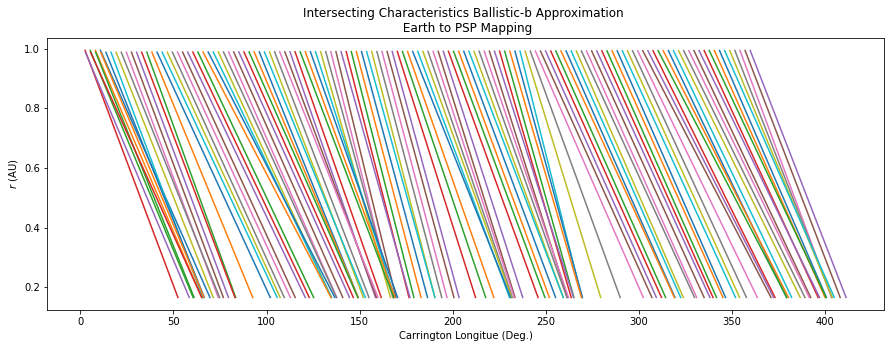

In [53]:
fig, ax = plt.subplots(figsize = (15,5))


for ii in np.arange(0, len(earth_coords.lon), 5):
    phi_location = (earth_coords.lon[ii].value)*(np.pi/180)
    radial_location = np.linspace(earth_coords.radius.to(u.km)[ii], r_min[0].to(u.km), nrout)
    curr_velocity = omni_data.quantity('V').value[ii]

    if not np.isnan(curr_velocity):
        phi_shift_vec = compute_phi_shift_forward(p=phi_location, 
                                                     r=radial_location.value,
                                                     v=curr_velocity) 
        _ = ax.plot(phi_shift_vec*(180/np.pi), radial_location.to(u.AU))

_ = ax.set_xlabel("Carrington Longitue (Deg.)")
_ = ax.set_ylabel("$r$ (AU)")
_ = ax.set_title("Intersecting Characteristics Ballistic-b Approximation \n Earth to PSP Mapping")
plt.savefig('figures/psp/'+ case_study + '/intersecting_characteristics_ballistic_b' + str(cr) +'.png')

# HUX-b Technique

# 1D interpolation - input $\phi$ ranges from [0, 2$\pi$]

In [54]:
# drop NaNs
nan_idx = np.isfinite(omni_data.quantity('V').value)
v_vec = omni_data.quantity('V').value[nan_idx]
interp = interpolate.interp1d(earth_coords.lon.value[nan_idx], \
                              v_vec, fill_value=(400, 400),  bounds_error=False)
omni_interp = interp(phi_array)

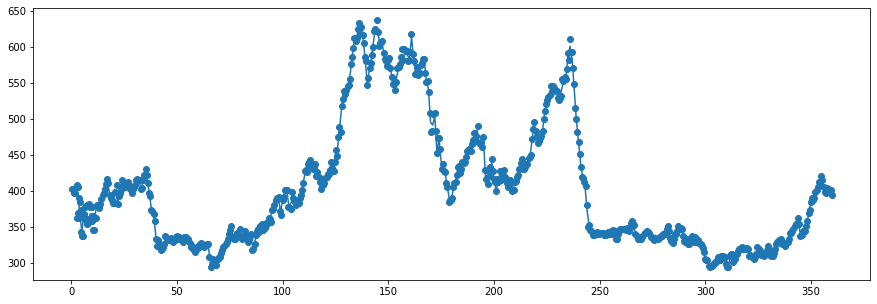

In [55]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(phi_array, omni_interp)
ax.scatter(earth_coords.lon.value, omni_data.quantity('V').value)

In [56]:
hux_b_full_res = apply_hux_b_model(r_final=omni_interp, 
                                         dr_vec=r_min.value[1:] - r_min.value[:-1], 
                                         dp_vec=dp_vec_hux, 
                                         r0=r_min[0].value, 
                                         add_v_acc=False).T

In [57]:
points = (phi_array, r_min)
xi = (psp_coords.lon.value, psp_coords.radius.value)
res_hux_b_interp = interpolate.interpn(points, hux_b_full_res, xi)

In [58]:
ballf = interpolate.interp1d(psp_coords.lon.to(u.rad), psp_coords.radius.to(u.km), fill_value="extrapolate")
psp_r_new = ballf(earth_coords.lon.to(u.rad))

C:\Users\Opali\AppData\Local\Continuum\anaconda3\envs\huxv1\lib\site-packages\scipy\interpolate\interpolate.py:623: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [59]:
res_ballistic_b = np.zeros(len(earth_coords.radius))
omega_rot=(2 * np.pi) / (25.38 * 86400)

for ii in range(len(earth_coords.radius)):
    phi_location = (earth_coords.lon[ii].to(u.rad)).value
    r0 = earth_coords.radius.value[ii]
    rf = psp_r_new[ii]
    curr_velocity = omni_data.quantity('V').value[ii]
    dr = rf - r0
    
    delta_phi = (omega_rot * dr) / curr_velocity
    phi_shifted = phi_location - delta_phi
    # force periodicity
    res_ballistic_b[ii] = phi_shifted % (2 * np.pi)

<ipython-input-59-3cac36b2a85b>:14: RuntimeWarning: invalid value encountered in double_scalars
  res_ballistic_b[ii] = phi_shifted % (2 * np.pi)


In [60]:
res_hux_b_min = apply_backwards_upwind_model(r_final=omni_interp, 
                                         dr_vec=r_min.value[1:] - r_min.value[:-1], 
                                         dp_vec=dp_vec_hux, 
                                         r0=r_min[0].value, 
                                         add_v_acc=False)

res_hux_b_mean = apply_backwards_upwind_model(r_final=omni_interp, 
                                         dr_vec=r_mean.value[1:] - r_mean.value[:-1], 
                                         dp_vec=dp_vec_hux, 
                                         r0=r_mean[0].value, 
                                         add_v_acc=False)

res_hux_b_max = apply_backwards_upwind_model(r_final=omni_interp, 
                                         dr_vec=r_max.value[1:] - r_max.value[:-1], 
                                         dp_vec=dp_vec_hux, 
                                         r0=r_max[0].value, 
                                         add_v_acc=False)

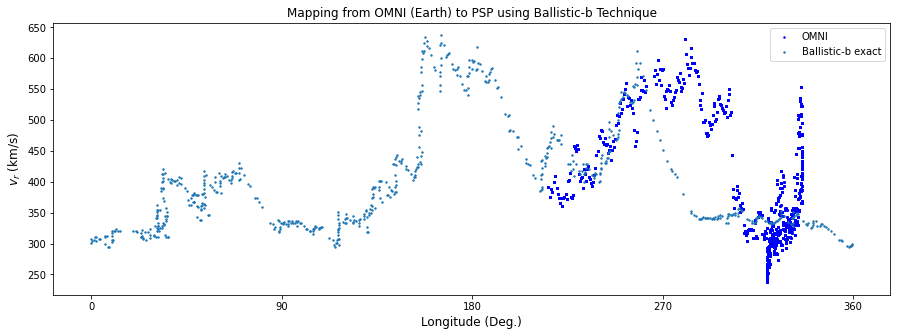

In [61]:
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.scatter(np.array(psp_coords.lon), psp_data.quantity('VR'), color="b", s=size, label="OMNI")

_ = ax.scatter(res_ballistic_b*(180/np.pi), omni_data.quantity('V').value, s=2,label="Ballistic-b exact")
_ = ax.set_xticks(ticks=[0, 90, 180, 270, 360])
_ = ax.set_title("Mapping from OMNI (Earth) to PSP using Ballistic-b Technique")
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()

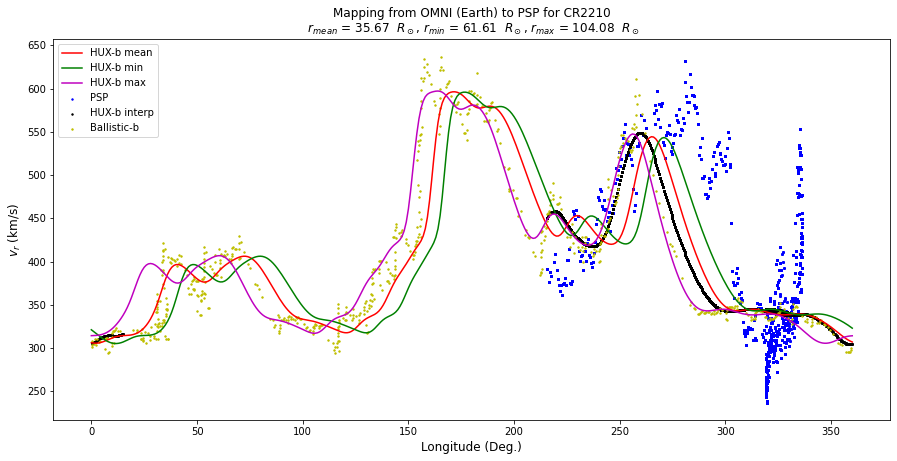

In [62]:
fig, ax = plt.subplots(figsize=(15, 7))
_ = ax.scatter(np.array(psp_coords.lon), psp_data.quantity('VR'), color="b", s=size, label="PSP")

_ = ax.plot(phi_array, res_hux_b_mean, color="r", label="HUX-b mean")
_ = ax.plot(phi_array, res_hux_b_min, color="g", label="HUX-b min")
_ = ax.plot(phi_array, res_hux_b_max, color="m", label="HUX-b max")
_ = ax.scatter(psp_coords.lon.value, res_hux_b_interp, color="k", s=2, label="HUX-b interp")


#_ = ax.scatter(res_ballistic_b_max, omni_data.quantity('V'),s=2, label="Ballistic-b max")
#_ = ax.scatter(res_ballistic_b_mean, omni_data.quantity('V'), s=2,label="Ballistic-b mean")
#_ = ax.scatter(res_ballistic_b_min, omni_data.quantity('V').value, s=2,label="Ballistic-b min")
_ = ax.scatter(res_ballistic_b *(180/np.pi), omni_data.quantity('V').value, color="y", s=2,label="Ballistic-b")



_ = ax.set_title("Mapping from OMNI (Earth) to PSP for CR" + str(cr) +"\n $r_{mean}$ = %.2f  $R_\odot$, $r_{min}$ = %.2f  $R_\odot$, $r_{max}$ = %.2f  $R_\odot$" % \
                       (np.min(psp_coords.radius).to(u.solRad).value,
                        np.mean(psp_coords.radius).to(u.solRad).value,
                        np.max(psp_coords.radius).to(u.solRad).value))
                 
_ = ax.set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
_ = ax.set_xlabel("Longitude (Deg.)", fontsize=fs1)
_ = ax.legend()
plt.savefig('figures/psp/'+ case_study + '/mapping_omni_to_psp' + str(cr) +'.png')

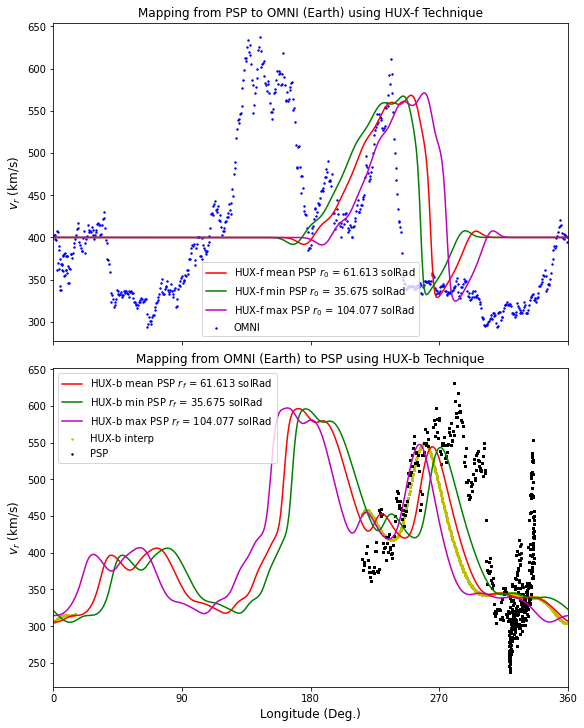

In [63]:
fig, ax = plt.subplots(nrows=2, ncols=1, constrained_layout=True, sharex=True)

ax[0].set_xlim(0, 360)
ax[0].set_title("Mapping from PSP to OMNI (Earth) using HUX-f Technique", fontsize=fs1)
ax[0].set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
ax[0].set_xticks(ticks=[0, 90, 180, 270, 360])

ax[0].scatter(np.array(earth_coords.lon), omni_data.quantity('V'), color="b", s=size, label="OMNI")

ax[0].plot(phi_array, res_hux_f_mean, color="r", label="HUX-f mean PSP $r_{0}$ = "+ 
           str(np.round(np.mean(psp_coords.radius).to(u.solRad), 3)))
ax[0].plot(phi_array, res_hux_f_min, color="g", label="HUX-f min PSP $r_{0}$ = "+ 
            str(np.round(np.min(psp_coords.radius).to(u.solRad), 3)))
ax[0].plot(phi_array, res_hux_f_max, color="m", label="HUX-f max PSP $r_{0}$ = " +
            str(np.round(np.max(psp_coords.radius).to(u.solRad), 3)))
ax[0].legend()


ax[1].set_xlim(0, 360)
ax[1].set_title("Mapping from OMNI (Earth) to PSP using HUX-b Technique", fontsize=fs1)
ax[1].set_ylabel(r'$v_{r}$ (km/s)', fontsize=fs1)
ax[1].set_xlabel("Longitude (Deg.)", fontsize=fs1)
ax[1].set_xticks(ticks=[0, 90, 180, 270, 360])

ax[1].plot(phi_array, res_hux_b_mean, color="r", label="HUX-b mean PSP $r_{f}$ = "+ 
           str(np.round(np.mean(psp_coords.radius).to(u.solRad), 3)))
ax[1].plot(phi_array, res_hux_b_min, color="g", label="HUX-b min PSP $r_{f}$ = "+ 
            str(np.round(np.min(psp_coords.radius).to(u.solRad), 3)))
ax[1].plot(phi_array, res_hux_b_max, color="m", label="HUX-b max PSP $r_{f}$ = " +
            str(np.round(np.max(psp_coords.radius).to(u.solRad), 3)))
ax[1].scatter(psp_coords.lon.value, res_hux_b_interp, color="y", s=2, label="HUX-b interp")
ax[1].scatter(lon_psp, psp_data.quantity('VR'), color="k", s=size,label="PSP")


ax[1].legend()
#plt.savefig('figures/psp/'+ case_study + '/mapping_omni_to_psp_and_back_cr' + str(cr) +'.png')